In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
import sklearn
import re
from urllib.parse import urlparse, parse_qs
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.utils import plot_model
from IPython.display import Image
# from tensorflow.keras.callbacks import EarlyStopping # 조기종료 사용 시 import

# 데이터셋 로드
df = pd.read_csv('/content/drive/MyDrive/2024-2 ML project/malicious_phish.csv')

In [3]:
# 1. 라벨 인코딩
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['type'])
y = to_categorical(df['label_encoded'])

df

,url,type,label_encoded
0,br-icloud.com.br,phishing,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,3
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3


In [4]:
# 2. 텍스트 데이터 전처리
urls = df['url'].values
max_sequence_length = 200     # 시퀀스 길이 200으로 고정
max_num_words = 10000         # 빈도수 높은 상위 10000개의 단어 고려
embedding_dim = 128

tokenizer = Tokenizer(num_words=max_num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(urls)
seq_data = tokenizer.texts_to_sequences(urls)
seq_data = pad_sequences(seq_data, maxlen=max_sequence_length)

In [5]:
# 3. 특성 추출 데이터프레임
# URL의 type을 매핑
df_features = pd.DataFrame()
df_features['url'] = df['url']

df_features

,url
0,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html
2,bopsecrets.org/rexroth/cr/1.htm
3,http://www.garage-pirenne.be/index.php?option=...
4,http://adventure-nicaragua.net/index.php?optio...
...,...
651186,xbox360.ign.com/objects/850/850402.html
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/
651188,www.gamespot.com/xbox360/action/deadspace/
651189,en.wikipedia.org/wiki/Dead_Space_(video_game)


In [6]:
# URL의 길이
df_features['url_length'] = df['url'].apply(len)

df_features

,url,url_length
0,br-icloud.com.br,16
1,mp3raid.com/music/krizz_kaliko.html,35
2,bopsecrets.org/rexroth/cr/1.htm,31
3,http://www.garage-pirenne.be/index.php?option=...,88
4,http://adventure-nicaragua.net/index.php?optio...,235
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,39
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,44
651188,www.gamespot.com/xbox360/action/deadspace/,42
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),45


In [7]:
# IP 주소 포함 여부
def has_ip(url):
  return int(bool(re.search(r'\d+\.\d+\.\d+\.\d+', url)))

df_features['has_ip'] = df['url'].apply(has_ip)

df_features

,url,url_length,has_ip
0,br-icloud.com.br,16,0
1,mp3raid.com/music/krizz_kaliko.html,35,0
2,bopsecrets.org/rexroth/cr/1.htm,31,0
3,http://www.garage-pirenne.be/index.php?option=...,88,0
4,http://adventure-nicaragua.net/index.php?optio...,235,0
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,39,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,44,0
651188,www.gamespot.com/xbox360/action/deadspace/,42,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),45,0


In [8]:
# URL이 'https://'로 시작하는지 여부
def is_https(url):
  return int(url.startswith('https://'))

df_features['is_https'] = df['url'].apply(is_https)
df_features

,url,url_length,has_ip,is_https
0,br-icloud.com.br,16,0,0
1,mp3raid.com/music/krizz_kaliko.html,35,0,0
2,bopsecrets.org/rexroth/cr/1.htm,31,0,0
3,http://www.garage-pirenne.be/index.php?option=...,88,0,0
4,http://adventure-nicaragua.net/index.php?optio...,235,0,0
...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,39,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,44,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,42,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),45,0,0


In [9]:
# 숫자의 개수
def digit_count(url):
  return sum(c.isdigit() for c in url)

df_features['digit_count'] = df['url'].apply(digit_count)

df_features

,url,url_length,has_ip,is_https,digit_count
0,br-icloud.com.br,16,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,35,0,0,1
2,bopsecrets.org/rexroth/cr/1.htm,31,0,0,1
3,http://www.garage-pirenne.be/index.php?option=...,88,0,0,7
4,http://adventure-nicaragua.net/index.php?optio...,235,0,0,22
...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,39,0,0,12
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,44,0,0,7
651188,www.gamespot.com/xbox360/action/deadspace/,42,0,0,3
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),45,0,0,0


In [10]:
# 영문자의 개수
def letter_count(url):
  return sum(c.isalpha() for c in url)

df_features['letter_count'] = df['url'].apply(letter_count)
df_features

,url,url_length,has_ip,is_https,digit_count,letter_count
0,br-icloud.com.br,16,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,35,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,31,0,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,88,0,0,7,63
4,http://adventure-nicaragua.net/index.php?optio...,235,0,0,22,199
...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,39,0,0,12,21
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,44,0,0,7,29
651188,www.gamespot.com/xbox360/action/deadspace/,42,0,0,3,33
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),45,0,0,0,36


In [11]:
# 찾고자 하는 TLD 목록
tld_list = ['.tk', '.buzz', '.xyz', '.top', '.ga', '.ml', '.info', '.cf', '.gq',
            '.icu', '.wang', '.live', '.host', '.shop', '.vip', '.id', '.cc',
            '.br', '.ci', '.zw', '.sx', '.mw']

# TLD 개수
df_features['tld_count'] = df['url'].apply(lambda x: sum(x.endswith(tld) for tld in tld_list))

df_features

,url,url_length,has_ip,is_https,digit_count,letter_count,tld_count
0,br-icloud.com.br,16,0,0,0,13,1
1,mp3raid.com/music/krizz_kaliko.html,35,0,0,1,29,0
2,bopsecrets.org/rexroth/cr/1.htm,31,0,0,1,25,0
3,http://www.garage-pirenne.be/index.php?option=...,88,0,0,7,63,0
4,http://adventure-nicaragua.net/index.php?optio...,235,0,0,22,199,0
...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,39,0,0,12,21,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,44,0,0,7,29,0
651188,www.gamespot.com/xbox360/action/deadspace/,42,0,0,3,33,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),45,0,0,0,36,0


In [12]:
# 특수 문자의 갯수
def count_special_chars(url):
    non_alpha_num = re.findall(r'\W',url)
    return len(non_alpha_num)

df_features['special_chars_count'] = df['url'].apply(count_special_chars)

df_features

,url,url_length,has_ip,is_https,digit_count,letter_count,tld_count,special_chars_count
0,br-icloud.com.br,16,0,0,0,13,1,3
1,mp3raid.com/music/krizz_kaliko.html,35,0,0,1,29,0,4
2,bopsecrets.org/rexroth/cr/1.htm,31,0,0,1,25,0,5
3,http://www.garage-pirenne.be/index.php?option=...,88,0,0,7,63,0,16
4,http://adventure-nicaragua.net/index.php?optio...,235,0,0,22,199,0,13
...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,39,0,0,12,21,0,6
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,44,0,0,7,29,0,8
651188,www.gamespot.com/xbox360/action/deadspace/,42,0,0,3,33,0,6
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),45,0,0,0,36,0,6


In [13]:
def count_keyword_flags(url):
    # 찾고자 하는 키워드 목록
    keywords = [
        "php", "index", "option","article", "content", "html", "view", "component"
    ]

    # URL을 소문자로 변환
    url_lower = url.lower()

    # 각 키워드가 포함되어 있는지 여부를 1 또는 0으로 반환
    return {keyword: (1 if keyword in url_lower else 0) for keyword in keywords}

# 각 URL에 대해 키워드 포함 여부를 데이터프레임으로 변환
keyword_flags_df = df['url'].apply(count_keyword_flags).apply(pd.Series)

# 기존 데이터프레임에 키워드 포함 여부 데이터프레임을 병합
df_features = pd.concat([df_features, keyword_flags_df], axis=1)

df_features

,url,url_length,has_ip,is_https,digit_count,letter_count,tld_count,special_chars_count,php,index,option,article,content,html,view,component
0,br-icloud.com.br,16,0,0,0,13,1,3,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,35,0,0,1,29,0,4,0,0,0,0,0,1,0,0
2,bopsecrets.org/rexroth/cr/1.htm,31,0,0,1,25,0,5,0,0,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,88,0,0,7,63,0,16,1,1,1,1,1,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,235,0,0,22,199,0,13,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,39,0,0,12,21,0,6,0,0,0,0,0,1,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,44,0,0,7,29,0,8,0,0,0,0,0,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,42,0,0,3,33,0,6,0,0,0,0,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),45,0,0,0,36,0,6,0,0,0,0,0,0,0,0


In [14]:
def count_slash(url):
    # '/'의 개수 계산
    return url.count('/')

def count_hyphen(url):
    # '-'의 개수 계산
    return url.count('-')

def count_dot(url):
    # '.'의 개수 계산
    return url.count('.')

def count_underscore(url):
    # '_'의 개수 계산
    return url.count('_')

def count_equals(url):
    # '='의 개수 계산
    return url.count('=')

def count_question(url):
    # '_'의 개수 계산
    return url.count('?')

def count_percent(url):
    # '%'의 개수 계산
    return url.count('%')

df_features['slash_count'] = df['url'].apply(lambda x: count_slash(x))
df_features['hyphen_count'] = df['url'].apply(lambda x: count_hyphen(x))
df_features['underscore_count'] = df['url'].apply(lambda x: count_underscore(x))
df_features['dot_count'] = df['url'].apply(lambda x: count_dot(x))
df_features['equals_count'] = df['url'].apply(lambda x: count_equals(x))
df_features['question_count'] = df['url'].apply(lambda x: count_question(x))
df_features['percent_count'] = df['url'].apply(lambda x: count_percent(x))

# 결과 확인
df_features

,url,url_length,has_ip,is_https,digit_count,letter_count,tld_count,special_chars_count,php,index,...,html,view,component,slash_count,hyphen_count,underscore_count,dot_count,equals_count,question_count,percent_count
0,br-icloud.com.br,16,0,0,0,13,1,3,0,0,...,0,0,0,0,1,0,2,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,35,0,0,1,29,0,4,0,0,...,1,0,0,2,0,1,2,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,31,0,0,1,25,0,5,0,0,...,0,0,0,3,0,0,2,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,88,0,0,7,63,0,16,1,1,...,0,1,0,3,1,2,3,4,1,0
4,http://adventure-nicaragua.net/index.php?optio...,235,0,0,22,199,0,13,1,1,...,0,0,1,3,1,1,2,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,39,0,0,12,21,0,6,0,0,...,1,0,0,3,0,0,3,0,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,44,0,0,7,29,0,8,0,0,...,0,0,0,4,2,0,2,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,42,0,0,3,33,0,6,0,0,...,0,0,0,4,0,0,2,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),45,0,0,0,36,0,6,0,0,...,0,0,0,2,0,3,2,0,0,0


In [15]:

# URL의 parameter 개수
def count_url_parameters(url):
    # URL 파싱
    parsed_url = urlparse(url)

    # URL로부터 query 추출
    query = parsed_url.query

    # parse_qs() 이용하여 query 분석
    parameters = parse_qs(query)

    # parameter 개수 리턴
    return len(parameters)

df_features['param_count'] = df['url'].apply(count_url_parameters)

df_features

,url,url_length,has_ip,is_https,digit_count,letter_count,tld_count,special_chars_count,php,index,...,view,component,slash_count,hyphen_count,underscore_count,dot_count,equals_count,question_count,percent_count,param_count
0,br-icloud.com.br,16,0,0,0,13,1,3,0,0,...,0,0,0,1,0,2,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,35,0,0,1,29,0,4,0,0,...,0,0,2,0,1,2,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,31,0,0,1,25,0,5,0,0,...,0,0,3,0,0,2,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,88,0,0,7,63,0,16,1,1,...,1,0,3,1,2,3,4,1,0,4
4,http://adventure-nicaragua.net/index.php?optio...,235,0,0,22,199,0,13,1,1,...,0,1,3,1,1,2,3,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,39,0,0,12,21,0,6,0,0,...,0,0,3,0,0,3,0,0,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,44,0,0,7,29,0,8,0,0,...,0,0,4,2,0,2,0,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,42,0,0,3,33,0,6,0,0,...,0,0,4,0,0,2,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),45,0,0,0,36,0,6,0,0,...,0,0,2,0,3,2,0,0,0,0


In [16]:
# directory 개수
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df_features['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

df_features

,url,url_length,has_ip,is_https,digit_count,letter_count,tld_count,special_chars_count,php,index,...,component,slash_count,hyphen_count,underscore_count,dot_count,equals_count,question_count,percent_count,param_count,count_dir
0,br-icloud.com.br,16,0,0,0,13,1,3,0,0,...,0,0,1,0,2,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,35,0,0,1,29,0,4,0,0,...,0,2,0,1,2,0,0,0,0,2
2,bopsecrets.org/rexroth/cr/1.htm,31,0,0,1,25,0,5,0,0,...,0,3,0,0,2,0,0,0,0,3
3,http://www.garage-pirenne.be/index.php?option=...,88,0,0,7,63,0,16,1,1,...,0,3,1,2,3,4,1,0,4,1
4,http://adventure-nicaragua.net/index.php?optio...,235,0,0,22,199,0,13,1,1,...,1,3,1,1,2,3,1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,39,0,0,12,21,0,6,0,0,...,0,3,0,0,3,0,0,0,0,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,44,0,0,7,29,0,8,0,0,...,0,4,2,0,2,0,0,0,0,4
651188,www.gamespot.com/xbox360/action/deadspace/,42,0,0,3,33,0,6,0,0,...,0,4,0,0,2,0,0,0,0,4
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),45,0,0,0,36,0,6,0,0,...,0,2,0,3,2,0,0,0,0,2


In [17]:
# 이상 url 탐지
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df_features['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

df_features

,url,url_length,has_ip,is_https,digit_count,letter_count,tld_count,special_chars_count,php,index,...,slash_count,hyphen_count,underscore_count,dot_count,equals_count,question_count,percent_count,param_count,count_dir,abnormal_url
0,br-icloud.com.br,16,0,0,0,13,1,3,0,0,...,0,1,0,2,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,35,0,0,1,29,0,4,0,0,...,2,0,1,2,0,0,0,0,2,0
2,bopsecrets.org/rexroth/cr/1.htm,31,0,0,1,25,0,5,0,0,...,3,0,0,2,0,0,0,0,3,0
3,http://www.garage-pirenne.be/index.php?option=...,88,0,0,7,63,0,16,1,1,...,3,1,2,3,4,1,0,4,1,1
4,http://adventure-nicaragua.net/index.php?optio...,235,0,0,22,199,0,13,1,1,...,3,1,1,2,3,1,0,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,39,0,0,12,21,0,6,0,0,...,3,0,0,3,0,0,0,0,3,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,44,0,0,7,29,0,8,0,0,...,4,2,0,2,0,0,0,0,4,0
651188,www.gamespot.com/xbox360/action/deadspace/,42,0,0,3,33,0,6,0,0,...,4,0,0,2,0,0,0,0,4,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),45,0,0,0,36,0,6,0,0,...,2,0,3,2,0,0,0,0,2,0


In [18]:
# 'www' 갯수
df_features['count_www'] = df['url'].apply(lambda i: i.count('www'))

df_features

,url,url_length,has_ip,is_https,digit_count,letter_count,tld_count,special_chars_count,php,index,...,hyphen_count,underscore_count,dot_count,equals_count,question_count,percent_count,param_count,count_dir,abnormal_url,count_www
0,br-icloud.com.br,16,0,0,0,13,1,3,0,0,...,1,0,2,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,35,0,0,1,29,0,4,0,0,...,0,1,2,0,0,0,0,2,0,0
2,bopsecrets.org/rexroth/cr/1.htm,31,0,0,1,25,0,5,0,0,...,0,0,2,0,0,0,0,3,0,0
3,http://www.garage-pirenne.be/index.php?option=...,88,0,0,7,63,0,16,1,1,...,1,2,3,4,1,0,4,1,1,1
4,http://adventure-nicaragua.net/index.php?optio...,235,0,0,22,199,0,13,1,1,...,1,1,2,3,1,0,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,39,0,0,12,21,0,6,0,0,...,0,0,3,0,0,0,0,3,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,44,0,0,7,29,0,8,0,0,...,2,0,2,0,0,0,0,4,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,42,0,0,3,33,0,6,0,0,...,0,0,2,0,0,0,0,4,0,1
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),45,0,0,0,36,0,6,0,0,...,0,3,2,0,0,0,0,2,0,0


In [19]:
# 의심스러운 URL 탐지
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0

df_features['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))

df_features

,url,url_length,has_ip,is_https,digit_count,letter_count,tld_count,special_chars_count,php,index,...,underscore_count,dot_count,equals_count,question_count,percent_count,param_count,count_dir,abnormal_url,count_www,sus_url
0,br-icloud.com.br,16,0,0,0,13,1,3,0,0,...,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,35,0,0,1,29,0,4,0,0,...,1,2,0,0,0,0,2,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,31,0,0,1,25,0,5,0,0,...,0,2,0,0,0,0,3,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,88,0,0,7,63,0,16,1,1,...,2,3,4,1,0,4,1,1,1,0
4,http://adventure-nicaragua.net/index.php?optio...,235,0,0,22,199,0,13,1,1,...,1,2,3,1,0,3,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,39,0,0,12,21,0,6,0,0,...,0,3,0,0,0,0,3,0,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,44,0,0,7,29,0,8,0,0,...,0,2,0,0,0,0,4,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,42,0,0,3,33,0,6,0,0,...,0,2,0,0,0,0,4,0,1,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),45,0,0,0,36,0,6,0,0,...,3,2,0,0,0,0,2,0,0,0


In [20]:
# 특성 데이터프레임에서 url column 제거
df_features = df_features.drop(columns=['url'])

# x_val의 배열 순서에 맞는 열 이름을 추출
x_val_column_names = list(df_features.columns)

# 열 이름 출력
print("x_val 배열의 열 이름 (순서대로):")
for idx, name in enumerate(x_val_column_names):
    print(f"Feature_{idx}: {name}")

x_val 배열의 열 이름 (순서대로):
Feature_0: url_length
Feature_1: has_ip
Feature_2: is_https
Feature_3: digit_count
Feature_4: letter_count
Feature_5: tld_count
Feature_6: special_chars_count
Feature_7: php
Feature_8: index
Feature_9: option
Feature_10: article
Feature_11: content
Feature_12: html
Feature_13: view
Feature_14: component
Feature_15: slash_count
Feature_16: hyphen_count
Feature_17: underscore_count
Feature_18: dot_count
Feature_19: equals_count
Feature_20: question_count
Feature_21: percent_count
Feature_22: param_count
Feature_23: count_dir
Feature_24: abnormal_url
Feature_25: count_www
Feature_26: sus_url


In [21]:
# 4. 수치형 데이터 표준화
scaler = StandardScaler()
num_data = scaler.fit_transform(df_features)

In [22]:
# 5. 데이터 분리
X_seq_train, X_seq_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    seq_data, num_data, y, test_size=0.2, random_state=42)

X_seq_train, X_seq_val, X_num_train, X_num_val, y_train, y_val = train_test_split(
    X_seq_train, X_num_train, y_train, test_size=0.25, random_state=42)  # 학습, 검증, 테스트용 데이터로 각각 60:20:20의 비율로 데이터 분리

In [23]:
dropout_rate = 0.3

# 6. LSTM과 MLP를 순차적으로 연결한 모델. 네 가지 모델 각각 사용시 주석 풀고 사용하면 됩니다.

# 6-1. LSTM Layer 1개, Dropout 0.3으로 구성한 모델
# seq_input = Input(shape=(max_sequence_length,), name="Sequence_Input")
# x = Embedding(input_dim=max_num_words, output_dim=embedding_dim, input_length=max_sequence_length)(seq_input)
# x = LSTM(64, return_sequences=False, name="LSTM_Layer")(x)

# num_input = Input(shape=(df_features.shape[1],), name="Numeric_Input")
# combined = Concatenate(name="Concatenate_Layer")([x, num_input])

# z = Dense(64, activation="relu", name="Dense_Layer_1")(combined)
# z = BatchNormalization()(z)
# z = Dropout(dropout_rate)(z)
# z = Dense(32, activation="relu", name="Dense_Layer_2")(z)
# z = Dropout(dropout_rate)(z)
# output = Dense(4, activation="softmax", name="Output_Layer")(z)

# model = Model(inputs=[seq_input, num_input], outputs=output)

# 6-2. LSTM Layer 1개. Dropout 없이 구성한 모델
seq_input = Input(shape=(max_sequence_length,), name="Sequence_Input")
x = Embedding(input_dim=max_num_words, output_dim=embedding_dim, input_length=max_sequence_length)(seq_input)
x = LSTM(64, return_sequences=False, name="LSTM_Layer")(x)

num_input = Input(shape=(df_features.shape[1],), name="Numeric_Input")
combined = Concatenate(name="Concatenate_Layer")([x, num_input])

z = Dense(64, activation="relu", name="Dense_Layer_1")(combined)
z = BatchNormalization()(z)
z = Dense(32, activation="relu", name="Dense_Layer_2")(z)
output = Dense(4, activation="softmax", name="Output_Layer")(z)

model = Model(inputs=[seq_input, num_input], outputs=output)

# 6-3. LSTM Layer 2개, Dropout 0.3으로 구성한 모델
# seq_input = Input(shape=(max_sequence_length,), name="Sequence_Input")
# x = Embedding(input_dim=max_num_words, output_dim=embedding_dim, input_length=max_sequence_length)(seq_input)
# x = LSTM(64, return_sequences=True, name="LSTM_Layer_01")(x)
# x = Dropout(dropout_rate)(x)
# x = LSTM(32, return_sequences=False, name="LSTM_Layer_02")(x)
# x = Dropout(dropout_rate)(x)

# num_input = Input(shape=(df_features.shape[1],), name="Numeric_Input")
# combined = Concatenate(name="Concatenate_Layer")([x, num_input])

# z = Dense(64, activation="relu", name="Dense_Layer_1")(combined)
# z = BatchNormalization()(z)
# z = Dropout(dropout_rate)(z)
# z = Dense(32, activation="relu", name="Dense_Layer_2")(z)
# z = Dropout(dropout_rate)(z)
# output = Dense(4, activation="softmax", name="Output_Layer")(z)

# model = Model(inputs=[seq_input, num_input], outputs=output)

# 6-4. LSTM 2개, Dropout 없이 구성한 모델
# seq_input = Input(shape=(max_sequence_length,), name="Sequence_Input")
# x = Embedding(input_dim=max_num_words, output_dim=embedding_dim, input_length=max_sequence_length)(seq_input)
# x = LSTM(64, return_sequences=True, name="LSTM_Layer_01")(x)
# x = LSTM(32, return_sequences=False, name="LSTM_Layer_02")(x)

# num_input = Input(shape=(df_features.shape[1],), name="Numeric_Input")
# combined = Concatenate(name="Concatenate_Layer")([x, num_input])

# z = Dense(64, activation="relu", name="Dense_Layer_1")(combined)
# z = BatchNormalization()(z)
# z = Dense(32, activation="relu", name="Dense_Layer_2")(z)
# output = Dense(4, activation="softmax", name="Output_Layer")(z)

# model = Model(inputs=[seq_input, num_input], outputs=output)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
# 7. 모델 컴파일
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Sequence_Input            │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 200, 128)       │      1,280,000 │ Sequence_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM_Layer_01 (LSTM)      │ (None, 64)             │         49,408 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Numeric_Input             │ (None, 27)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Concatenate_Layer         │ (None, 91)             │              0 │ LSTM_Layer_01[0][0],   │
│ (Concatenate)             │                        │                │ Numeric_Input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense_Layer_1 (Dense)     │ (None, 64)             │          5,888 │ Concatenate_Layer[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64)             │            256 │ Dense_Layer_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense_Layer_2 (Dense)     │ (None, 32)             │          2,080 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output_Layer (Dense)      │ (None, 4)              │            132 │ Dense_Layer_2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,337,764 (5.10 MB)

 Trainable params: 1,337,636 (5.10 MB)

 Non-trainable params: 128 (512.00 B)

In [25]:
# 조기 종료 콜백
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 8. 모델 학습
history = model.fit(
    [X_seq_train, X_num_train], y_train,
    validation_data=([X_seq_val, X_num_val], y_val),
    epochs=20,
    batch_size=128,
#    callbacks=[early_stopping]     # 조기 종료 사용 시

)

# 9. 모델 성능 평가
test_loss, test_accuracy = model.evaluate([X_seq_test, X_num_test], y_test, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/20
3053/3053 ━━━━━━━━━━━━━━━━━━━━ 73s 21ms/step - accuracy: 0.9370 - loss: 0.1855 - val_accuracy: 0.9812 - val_loss: 0.0590
Epoch 2/20
3053/3053 ━━━━━━━━━━━━━━━━━━━━ 80s 22ms/step - accuracy: 0.9837 - loss: 0.0505 - val_accuracy: 0.9822 - val_loss: 0.0549
Epoch 3/20
3053/3053 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - accuracy: 0.9865 - loss: 0.0408 - val_accuracy: 0.9828 - val_loss: 0.0549
Epoch 4/20
3053/3053 ━━━━━━━━━━━━━━━━━━━━ 84s 22ms/step - accuracy: 0.9879 - loss: 0.0360 - val_accuracy: 0.9827 - val_loss: 0.0550
Epoch 5/20
3053/3053 ━━━━━━━━━━━━━━━━━━━━ 65s 21ms/step - accuracy: 0.9891 - loss: 0.0327 - val_accuracy: 0.9829 - val_loss: 0.0574
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - accuracy: 0.9828 - loss: 0.0539
Test Loss: 0.0551
Test Accuracy: 0.9825


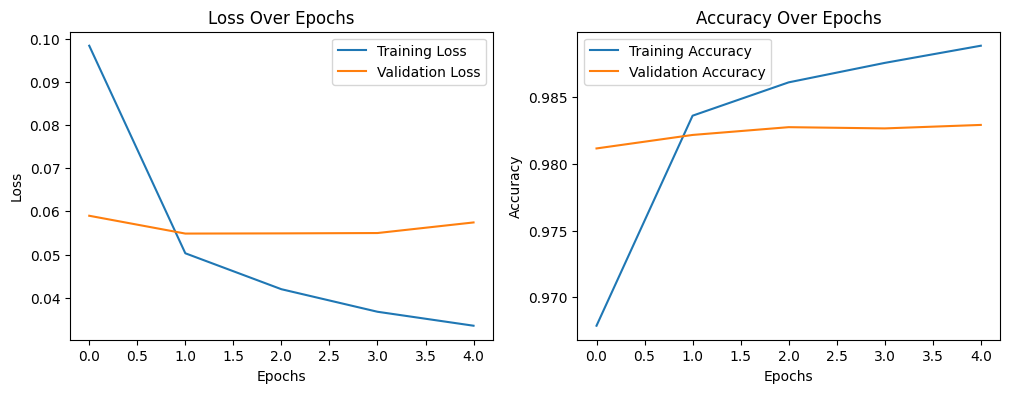

In [26]:
# 학습 손실 및 정확도 시각화
def plot_history(history):

    # 손실 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 학습 과정 시각화
plot_history(history)

In [27]:
# 모델 예측값 생성
y_pred = model.predict([X_seq_test, X_num_test])
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측 클래스
y_true_classes = np.argmax(y_test, axis=1)  # 실제 클래스

# classification_report 출력
report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:\n")
print(report)

4070/4070 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step
Classification Report:

              precision    recall  f1-score   support

      benign       0.99      0.99      0.99     85778
  defacement       0.99      1.00      0.99     19104
     malware       0.99      0.95      0.97      6521
    phishing       0.96      0.93      0.94     18836

    accuracy                           0.98    130239
   macro avg       0.98      0.97      0.97    130239
weighted avg       0.98      0.98      0.98    130239



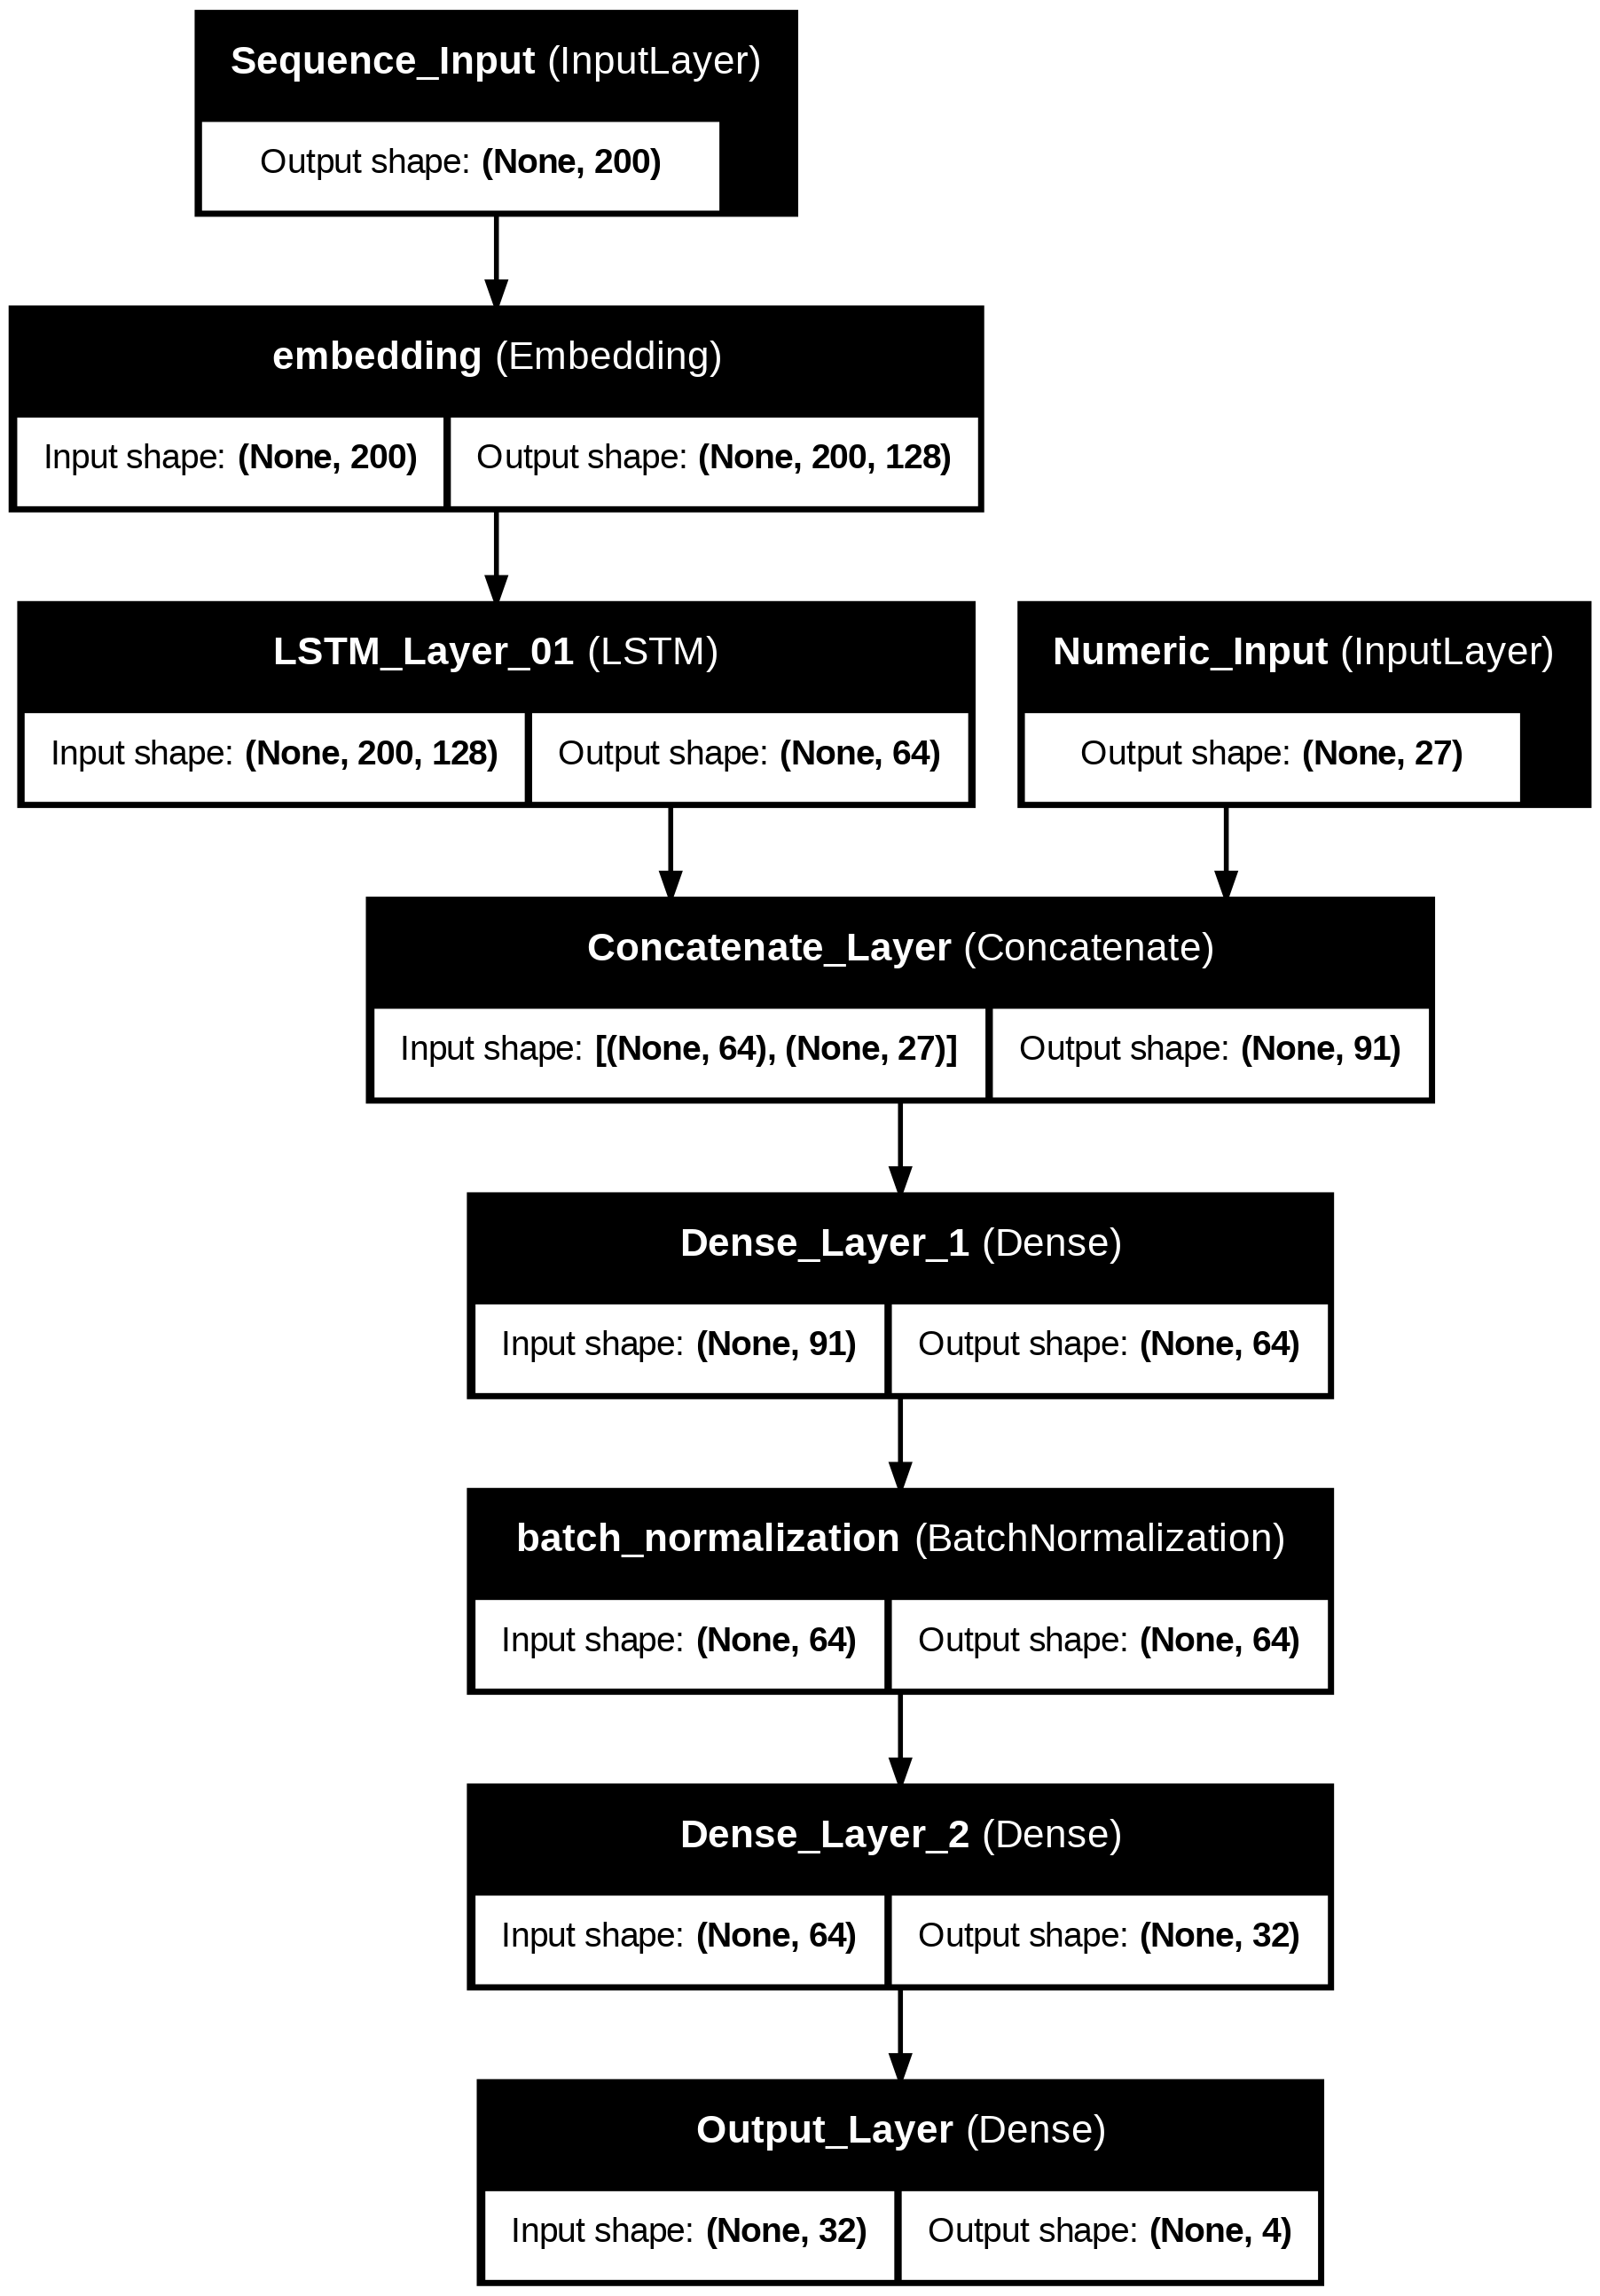

In [28]:
# 모델 시각화 파일 저장 및 출력
def visualize_model_in_colab(model, file_name="model_structure.png"):
    # 모델 구조 저장
    plot_model(
        model,
        to_file=file_name,
        show_shapes=True,
        show_layer_names=True
    )
    # 저장된 파일을 출력
    return Image(file_name)

# 실행
visualize_model_in_colab(model)